# Accident Analysis in Barcelona: Exploring Causes and Trends

In this notebook, I will analyze accident data managed by the Urban Guard in Barcelona. The process will involve data cleaning, exploratory data analysis (EDA) to identify key trends and insights, and the implementation of a modeling pipeline to evaluate factors contributing to accidents.

The ultimate goal is to derive actionable insights that can inform safety improvements in the city.

# Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from UTILS import InitialEDA, PreprocessingStarter, FeatureEngineering

# EDA

## Data Cleaning

In [41]:
data = pd.read_csv("./data/2023_accidents_causa_conductor_gu_bcn_.csv")

data.columns = data.columns.str.strip() #Num_postal had a typo

data.head()

,Numero_expedient,Codi_districte,Nom_districte,Codi_barri,Nom_barri,Codi_carrer,Nom_carrer,Num_postal,Descripcio_dia_setmana,NK_Any,Mes_any,Nom_mes,Dia_mes,Hora_dia,Descripcio_torn,Descripcio_causa_mediata,Coordenada_UTM_X_ED50,Coordenada_UTM_Y_ED50,Longitud_WGS84,Latitud_WGS84
0,2023S000699,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Dissabte,2023,2,Febrer,4,16,Tarda,Manca d'atenció a la conducció,430443.36,4585232.00,2.166596,41.413783
1,2023S005197,-1,Desconegut,-1,Desconegut,-1,Estatut de Catalunya ...,11,Divendres,2023,9,Setembre,1,13,Matí,No respectar distàncies,429493.73,4587108.15,2.155015,41.430598
2,2023S007430,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Divendres,2023,12,Desembre,15,11,Matí,No respectar distàncies,430443.36,4585232.00,2.166596,41.413783
3,2023S000961,-1,Desconegut,-1,Desconegut,-1,Amílcar ...,120,Dissabte,2023,1,Gener,28,14,Tarda,No respectat pas de vianants,430955.45,4586335.10,2.172596,41.423762
4,2023S006486,-1,Desconegut,-1,Desconegut,-1,Augusta / Hort de la Vila ...,NaN,Dijous,2023,11,Novembre,2,14,Tarda,Desobeir semàfor,426883.33,4583690.92,2.124189,41.399587


In [42]:
# There are lots of typos
eda = InitialEDA()

cat_cols = eda.get_categorical(data)

# Clean and replace spaces in each categorical column
for col in cat_cols:
    if data[col].isnull().any():
        data[col] = data[col].fillna('')  # Fill NaNs with an empty string
    data[col] = data[col].str.strip()          # Remove leading/trailing whitespace
    data[col] = data[col].str.replace(' ', '_')  # Replace spaces with underscores

In [43]:
print(f"Number of duplicate rows: {data.duplicated().sum()}")
print(f"Number of duplicate expedient: {data['Numero_expedient'].duplicated().sum()}")

# Duplicated expedient seem to be same accident but one has "Altres" in Descripcio_causa_mediata

Number of duplicate rows: 0
Number of duplicate expedient: 1176


In [44]:
data = data[~((data['Descripcio_causa_mediata'] == 'Altres') & 
                      data.duplicated(subset=['Numero_expedient'], keep=False))]

# Rest of duplicates are same accident with different cause. Just keep one
print(f"Number of duplicate expedient: {data['Numero_expedient'].duplicated().sum()}")

data.drop_duplicates(subset=['Numero_expedient'], keep='first', inplace=True)
print(f"Number of duplicate expedient after cleaning: {data['Numero_expedient'].duplicated().sum()}")

Number of duplicate expedient: 426
Number of duplicate expedient after cleaning: 0


Drop unknown districts

In [45]:
data = data[data['Nom_districte'] != 'Desconegut']

In [46]:
for col in data.columns:
    print("Nr. of unique values in", col, "is", data[col].nunique())

Nr. of unique values in Numero_expedient is 7631
Nr. of unique values in Codi_districte is 10
Nr. of unique values in Nom_districte is 10
Nr. of unique values in Codi_barri is 73
Nr. of unique values in Nom_barri is 73
Nr. of unique values in Codi_carrer is 1073
Nr. of unique values in Nom_carrer is 1040
Nr. of unique values in Num_postal is 1908
Nr. of unique values in Descripcio_dia_setmana is 7
Nr. of unique values in NK_Any is 1
Nr. of unique values in Mes_any is 12
Nr. of unique values in Nom_mes is 12
Nr. of unique values in Dia_mes is 31
Nr. of unique values in Hora_dia is 24
Nr. of unique values in Descripcio_torn is 3
Nr. of unique values in Descripcio_causa_mediata is 16
Nr. of unique values in Coordenada_UTM_X_ED50 is 4756
Nr. of unique values in Coordenada_UTM_Y_ED50 is 4752
Nr. of unique values in Longitud_WGS84 is 4770
Nr. of unique values in Latitud_WGS84 is 4770


Drop Codi_carrer

In [47]:
# There are streets with >1 Codi_carrer
df = data.groupby(['Codi_carrer', 'Nom_carrer']).size().reset_index(name='count')
df['Nom_carrer'].value_counts()

Nom_carrer
Sant_Antoni    3
Miramar        3
Poblenou       2
Flandes        2
Sant_Pau       2
              ..
Garrotxa       1
Gas            1
Gavà           1
Gaiarre        1
Can_Basté      1
Name: count, Length: 1040, dtype: int64

In [48]:
del(data['Codi_carrer'])

In [49]:
data.isnull().sum().sum()

0

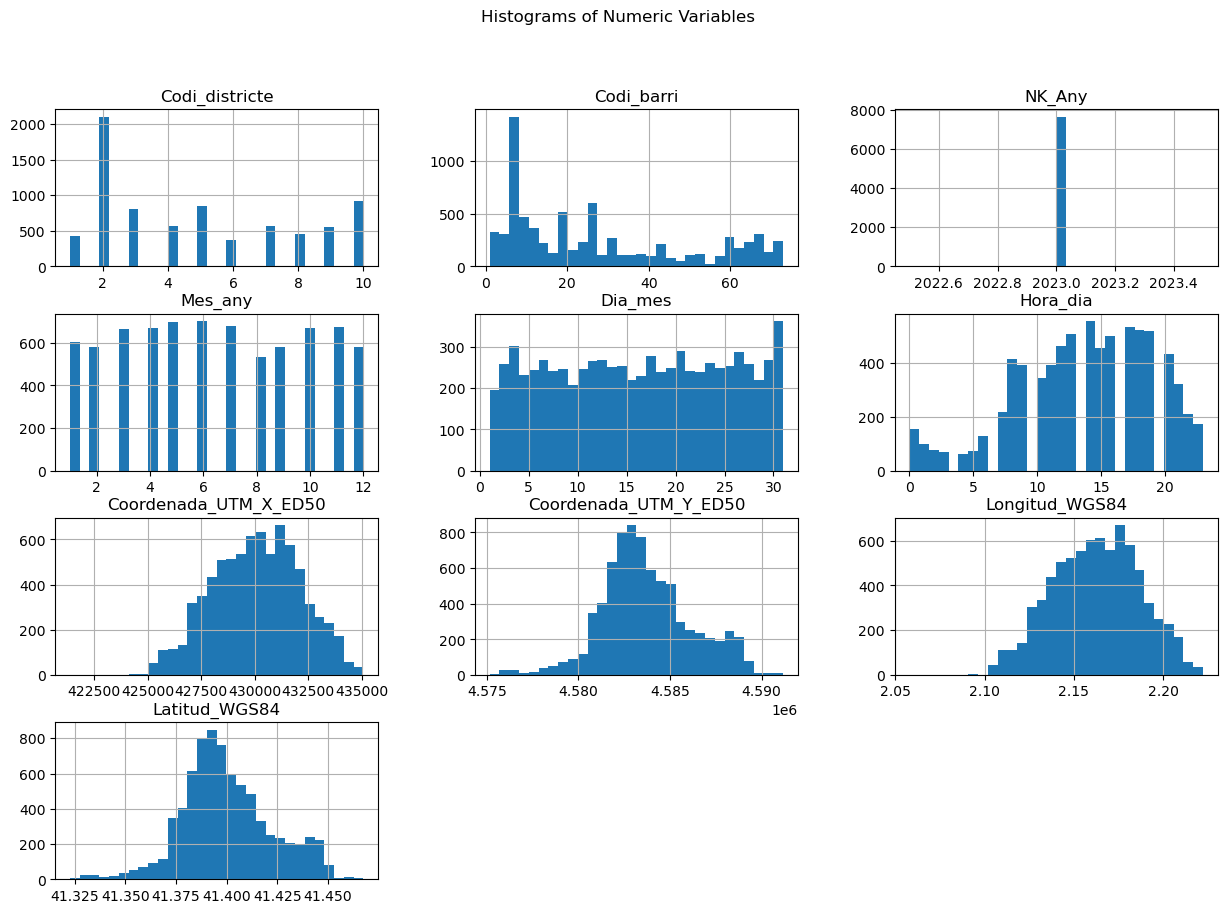

In [50]:
eda.plot_histograms(data)

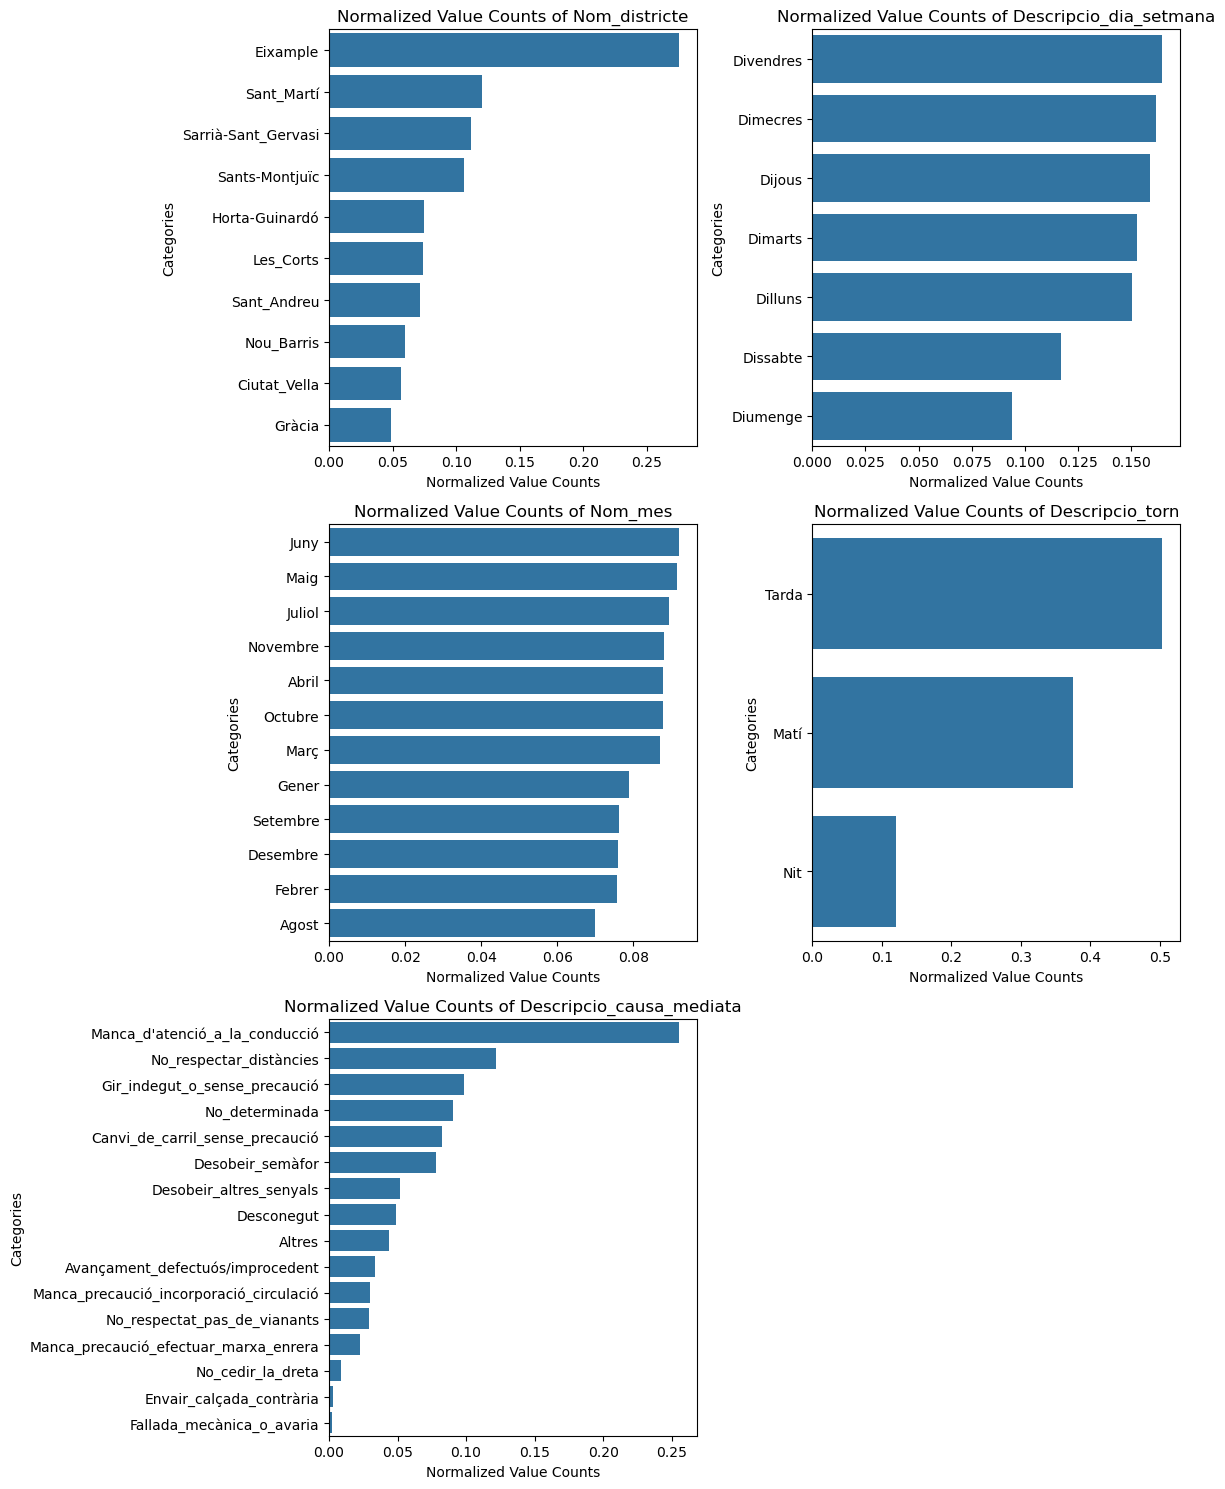

In [51]:
eda.plot_barplots_normalized(data, exclude=['Numero_expedient', 'Nom_barri', 'Nom_carrer', 'Num_postal'])

## Map view

In [52]:
# Load the districts GeoDataFrame --> Downloaded from https://opendata-ajuntament.barcelona.cat/data/ca/dataset/accidents_causa_conductor_gu_bcn/resource/5a040155-38b3-4b19-a4b0-c84a0618d363
districts = pd.read_csv("./data/BarcelonaCiutat_Districtes.csv")
districts['nom_districte'] = districts['nom_districte'].str.replace(' ', '_')
districts.head()

,Codi_Districte,nom_districte,geometria_etrs89,geometria_wgs84
0,1,Ciutat_Vella,"POLYGON ((431735.899600634 4582445.23444175, 4...","POLYGON ((2.18347683856251 41.390642940051, 2...."
1,2,Eixample,"POLYGON ((432035.336202865 4583668.43902139, 4...","POLYGON ((2.18692083199788 41.4016853455437, 2..."
2,3,Sants-Montjuïc,"POLYGON ((431601.608976907 4579536.03044858, 4...","POLYGON ((2.1821990169001 41.3644291256417, 2...."
3,4,Les_Corts,"POLYGON ((425056.8965533 4583675.91596755, 425...","POLYGON ((2.10344434732743 41.401132502692, 2...."
4,5,Sarrià-Sant_Gervasi,"POLYGON ((422050.616047581 4586562.54207296, 4...","POLYGON ((2.06711232318739 41.4268447598344, 2..."


In [53]:
unmatched_districts = []

# Loop to check if any district in data is missing in districts
for dist in data.Nom_districte.unique():
    if dist not in districts.nom_districte.to_list():
        unmatched_districts.append(dist)

# Check if all districts matched
if unmatched_districts:
    for dist in unmatched_districts:
        print(f"District not found: {dist}")
else:
    print("All districts match")

All districts match


### Barcelona heatmap showing density of accidents in 2023
High concentration in Eixample

In [54]:
import folium
from folium.plugins import HeatMap

# Prepare the data for the heatmap
heat_data = [[row['Latitud_WGS84'], row['Longitud_WGS84']] for index, row in data.iterrows()]

# Create a folium map centered on Barcelona
m = folium.Map(location=[41.41, 2.16], zoom_start=12.5, )
# Add the heatmap layer
HeatMap(heat_data, blur=30, min_opacity=0.2).add_to(m)

# Save to an HTML file or display directly in a Jupyter notebook
m.save("./viz/barcelona_heatmap.html")
m

In [55]:
import geopandas as gpd
from shapely import wkt

# Convert the WKT geometries (from 'geometria_wgs84') to Shapely objects
districts['geometry'] = districts['geometria_wgs84'].apply(wkt.loads)

# Create a GeoDataFrame from the CSV file, setting CRS to WGS84
districts = gpd.GeoDataFrame(districts, geometry='geometry', crs='epsg:4326')

# Count the number of events per district
event_counts = data.groupby('Nom_districte').size().reset_index(name='event_count')

# Merge the event counts with the districts GeoDataFrame
districts = districts.merge(event_counts, left_on='nom_districte', right_on='Nom_districte', how='left')
districts['event_count'] = np.log(districts['event_count'])

# Create a folium map centered on Barcelona
m = folium.Map(location=[41.41, 2.16], zoom_start=12.5)

# Add Choropleth to the map
folium.Choropleth(
    geo_data=districts.__geo_interface__,  # Convert GeoDataFrame to GeoJSON format
    name='choropleth',
    data=districts,
    columns=['nom_districte', 'event_count'],  # Data for choropleth
    key_on='feature.properties.nom_districte',  # Key to match districts by name
    fill_color='RdYlBu_r', 
    fill_opacity=0.6,
    line_opacity=0.5,
    legend_name='Accident Count by District (Log scale)'
).add_to(m)

# Save or display the map
m.save("./viz/barcelona_districts_event_map.html")
m

# Creating forecasting target

- I created an unique_id identifier with the combination of Codi_districte + Codi_barri.
- I created a date column with year, month and day features.
- I created a forecasting target of the number of accidents per day.

In [37]:
data['unique_id'] = data['Codi_districte'].astype(str) + '-' + data['Codi_barri'].astype(str)
print("Number of unique_id:", data['unique_id'].nunique())

data['ds'] = data.apply(lambda row: datetime.datetime(year=row['NK_Any'], 
                                                        month=row['Mes_any'], 
                                                        day=row['Dia_mes']), axis=1)

data = data.set_index('ds').sort_index()
print("Expected number of rows:", data['unique_id'].nunique()*365)
print("Actual number of rows:", data.shape[0])

Number of unique_id: 74
Expected number of rows: 27010
Actual number of rows: 8897


In [35]:
# Do every unique_id has every days info?
data.groupby('unique_id')['ds'].nunique()

unique_id
-1--1     80
1-1      113
1-2       80
1-3       81
1-4       96
        ... 
9-59     117
9-60     122
9-61      62
9-62      37
9-63      58
Name: ds, Length: 74, dtype: int64

# Feature Engineering

Public Holidays in Barcelona/Catalonia 2023
Here's a comprehensive list of the public holidays for 2023:

    January 1 (Sunday): New Year's Day
    January 6 (Friday): Epiphany (Three Kings' Day)
    April 7 (Friday): Good Friday
    April 10 (Monday): Easter Monday
    May 1 (Monday): Labor Day
    June 24 (Saturday): Saint John's Eve (Feast of St. John the Baptist)
    August 15 (Tuesday): Assumption Day
    September 11 (Monday): National Day of Catalonia
    October 12 (Thursday): Hispanic Day (National Holiday of Spain)
    November 1 (Wednesday): All Saints' Day
    December 6 (Wednesday): Constitution Day
    December 8 (Friday): Immaculate Conception Day
    December 25 (Monday): Christmas Day
    December 26 (Tuesday): St. Stephen's Day

Additional Notes

    In Barcelona, there's an additional holiday called La Mercè, which was observed on Monday, September 25, 2023 (in lieu of the actual date)2
    .